In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy.clients.fdsn import Client
from obspy.core.inventory.inventory import Inventory
from obspy.signal.filter import envelope
from obspy.clients.fdsn.header import FDSNNoDataException
from obspy import read, read_inventory
client = Client("IRIS")



In [2]:
# Earthquake variables
# eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
eq = uf.Earthquake(f'grids/Craig2013.xml')
eq_lat = eq.event['lat']
eq_lon = eq.event['lon']
eq_dep = eq.event['depth']


Start of Parsing for grids/Craig2013.xml
   ~~Detection stats~~
    Used a maximum azimuthal gap of 300 degrees and minimum station vector angle of 30 km
    Number of stations needed: 4
    Detection Time: 30.674257642857015
    Azimuthal Gap: 269.05049882392194
    Max Vector Angle: 90.79016360834348
    Maximum Epicentral Distance: 205.333298756688
Finished parsing grid.xml for: M7.5, 110 km SW of Edna Bay, Alaska, at 2013-01-05T08:58:14 (ID:ak0138esnzr)


In [3]:
EV_NAME = 'Craig2013'

# ObsPY variables
station_data = {}

or_time = '2013-01-05T08:58:14.000Z'
or_time = UTCDateTime(or_time)
starttime = or_time
endtime = or_time + 600

network = '*'
stations = 'ABBK,AJKS,AMJG,ARTY,AWPL'
# names = stations.split(',')

channel = 'HN*'
location = '*'


In [4]:
# Download data
st = client.get_waveforms(network=network, station=stations, location='*', channel=channel, starttime=starttime, endtime=endtime)
inv = client.get_stations(network=network, station=stations, location="*", channel=channel, starttime=starttime,
                                         endtime=endtime, level='response')

In [5]:
# EQ related information
for net in inv:    
    for station in net:
        name = station.code
        lat = station.latitude
        lon = station.longitude
        # Find closest grid point in ShakeMap grid and pga
        subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
        nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
        pga = eq.pga[nearest_index, 0]
        # Calculate epicentral and hypocentral distance, and first-arrival times
        epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
        hypo_dist = (epi_dist**2 + eq_dep**2)**.5
        p_arr = hypo_dist/eq.vel_p
        s_arr = hypo_dist/eq.vel_s
        surf_arr = hypo_dist/eq.vel_surf
        # Save the info into the data dict
        station_data[name] = {'lat': lat,
                              'lon': lon,
                              'epi_dist': epi_dist,
                              'hypo_dist': hypo_dist,
                              'pga': pga,
                              'p_arr': p_arr,
                              's_arr': s_arr,
                              'surf_arr': surf_arr}


In [6]:
#test cell for printing stuff
inv[0][0].code

'ABBK'

Number of traces: 15


Text(0.03, 0.5, 'Ground Acceleration $(m/s^2)$')

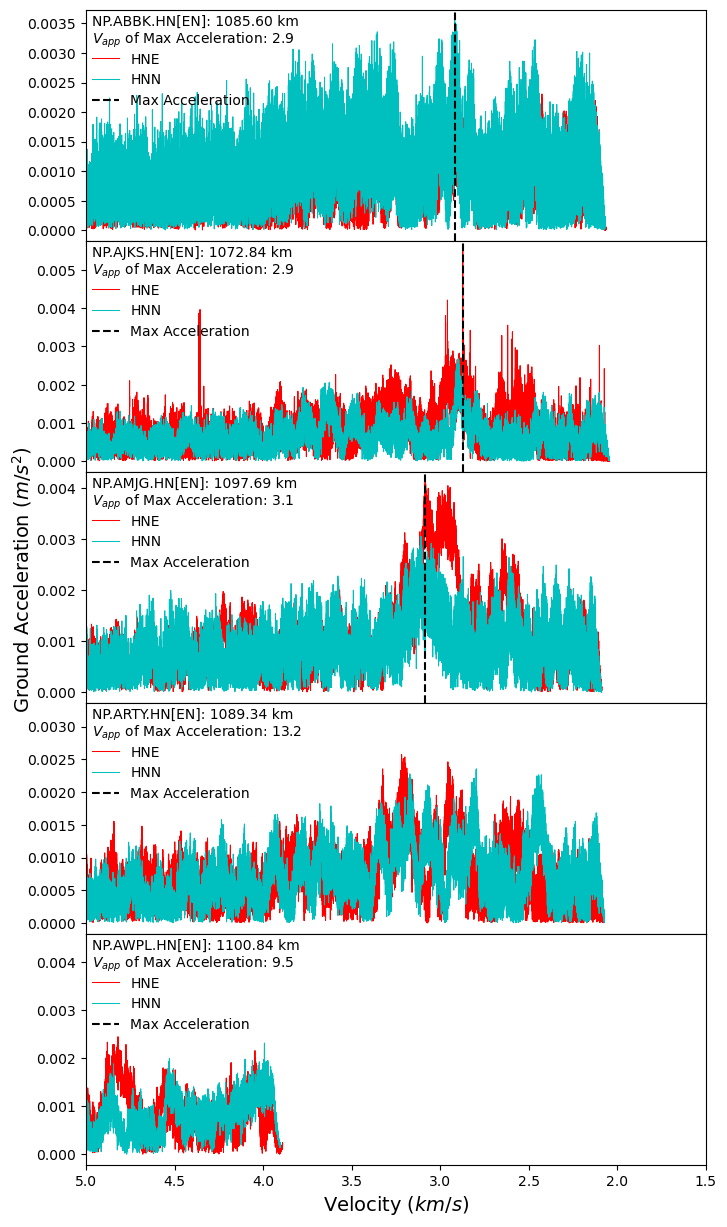

In [7]:
n_tr = len(st)
stringtotext = 'event, stationcode, hypodist, maxacc, vapp'
print('Number of traces:', n_tr)
alpha = 1
lw = 0.75
fs=14
vapp_list = []
st1 = st.copy()
# for i in len(st1):
#     tr = st1[i]
#     sample_rate = tr.stats.sampling_rate
    
    
st1.attach_response(inv)
st1 = st1.remove_response(output='ACC')

fig, ax = plt.subplots(nrows=n_tr // 3, sharex=True, figsize=(8,n_tr))
fig.subplots_adjust(hspace=0)
for i in range(n_tr // 3):
    sample = st1[i*3].stats.channel[0]
    chan = sample + channel[1] + '[EN]'

    code = st1[i*3].stats.station
    net = st1[i*3].stats.network
    distance = station_data[code]['hypo_dist']
    
    tr_e = st1[i*3].detrend('demean')
    tr_n = st1[i*3 + 1].detrend('demean')
    tr_z = st1[i*3 + 2].detrend('demean')
    
    env_e = envelope(tr_e.data)
    env_n = envelope(tr_n.data)
    env_z = envelope(tr_z.data)
    
    h_max_acc = 0
    h_max_ind = 0
    h_max_time = 0
    if np.max(env_e) >= np.max(env_n):
        h_max_ind = np.argmax(env_e)
        h_max_acc = np.max(env_n)
        h_max_time = tr_e.times()[h_max_ind]
    else:
        h_max_ind = np.argmax(env_n)
        h_max_acc = np.max(env_n)
        h_max_time = tr_n.times()[h_max_ind]
        
    # tr_e = st1[i*3]
    # tr_n = st1[i*3 + 1]
    # tr_z = st1[i*3 + 2]
    
    v_app_e = distance/tr_e.times()[1:]
    v_app_n = distance/tr_n.times()[1:]
    v_app_z = distance/tr_z.times()[1:]
    h_max_vapp = distance/h_max_time
    
    ax[i].plot(v_app_e, env_e[1:], c='r', label=tr_e.stats.channel, lw=lw, alpha=alpha)
    ax[i].plot(v_app_n, env_n[1:], c='c', label=tr_n.stats.channel, lw=lw, alpha=alpha)
    # ax[i].plot(v_app_z, env_z[1:], c='k', label=tr_z.stats.channel, lw=lw, alpha=alpha)    
    ax[i].axvline(h_max_vapp, ls='--', lw=2*lw, c='k', label='Max Acceleration')
    ax[i].text(.01, .98, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].text(.01, .91, r'$V_{app}$ of Max Acceleration: %.1f' % (np.round(h_max_vapp, 1)), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].legend(loc=(0.0, .55), frameon=False, fancybox=False)
    # ax[i].set_title('%s: %.2f km' % (code, distance))
    vapp_list.append(h_max_vapp)
    stringtotext += '\n%s, %s, %.2f, %.2f, %.2f' % (EV_NAME, code, distance, h_max_acc, h_max_vapp)
# plt.xscale('log')
plt.xlim(5, 1.5)
plt.xlabel(r'Velocity $(km/s)$', fontsize=fs)
fig.text(0.03, 0.5, r'Ground Acceleration $(m/s^2)$', va='center', rotation='vertical', fontsize=fs)


In [ ]:
print(vapp_list)
print(stringtotext)
with open(f'Vapps/{EV_NAME}_vapps.txt', 'w') as file:
    file.write(stringtotext)

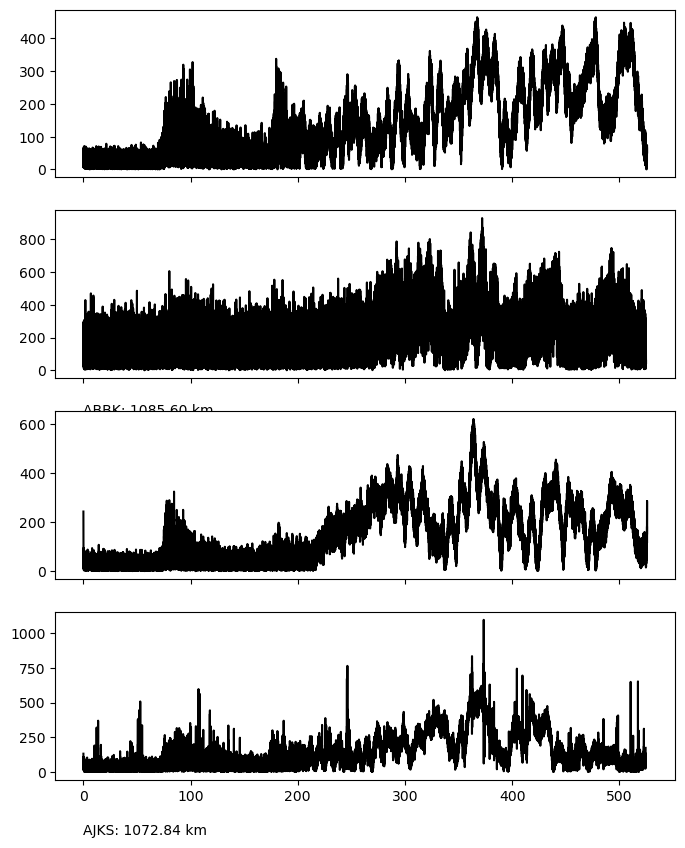

In [20]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,10))
for i in range(4):
    code = st1[i].stats.station
    distance = station_data[code]['hypo_dist']
    v_app = distance/st1[i].times()[1:]
    ax[i].plot(st1[i].times(), envelope(st[i].data), c='k')
    ax[i].text(0, np.max(st[i].data[1:])-1000, '%s: %.2f km' % (code, distance), va='top')

In [118]:
st[0].stats.network

'NP'

In [119]:
len(st)

15

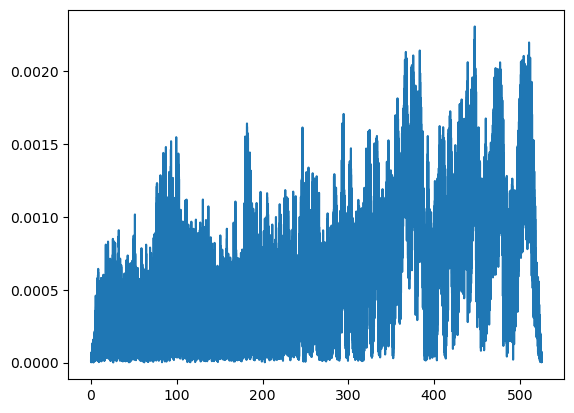

In [21]:
plt.figure()
plt.plot(st1[0].times(), envelope(st1[0].data))

In [121]:
st

15 Trace(s) in Stream:
NP.ABBK.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ARTY.01.HNE | 2013-01-05T08:00:00.000000Z - 201

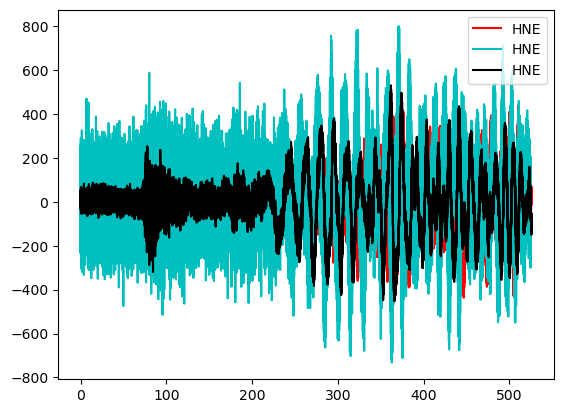

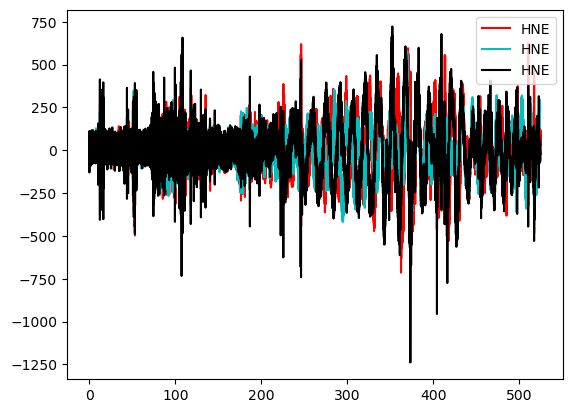

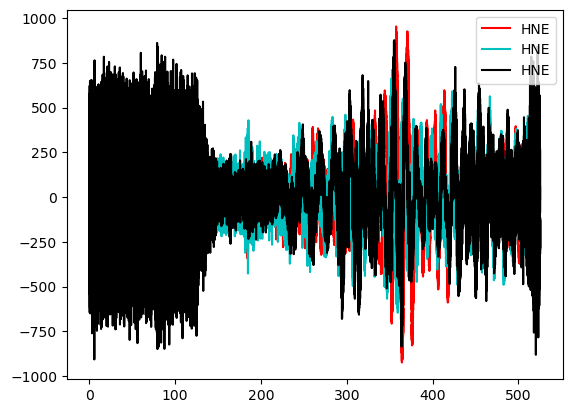

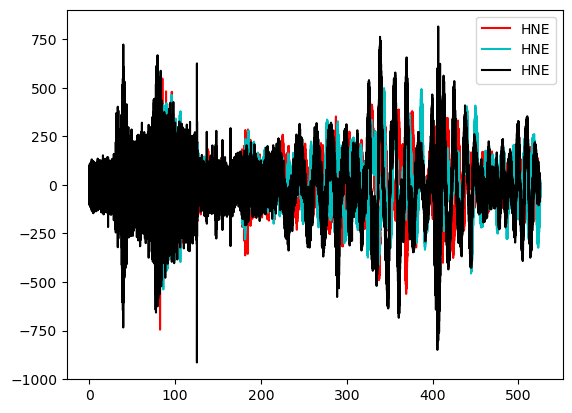

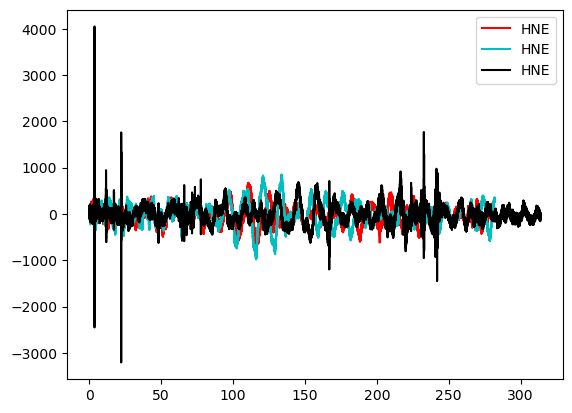

In [22]:
stt = st.copy()
stt.trim(starttime=starttime, endtime=endtime)

for i in range(len(stt)//3):
    plt.figure()
    # st[i].plot()
    code = stt[i*3].stats.station
    net = stt[i*3].stats.network
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    plt.plot(stt[i*3].times(), stt[i*3].data, c='r', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+1].times(), stt[i*3+1].data, c='c', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+2].times(), stt[i*3+2].data, c='k', label=stt[i*3].stats.channel)

    # plt.text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=plt.transAxes)
    plt.legend(loc='upper right')

In [123]:
st[0*3+1].times())

SyntaxError: unmatched ')' (265354340.py, line 1)

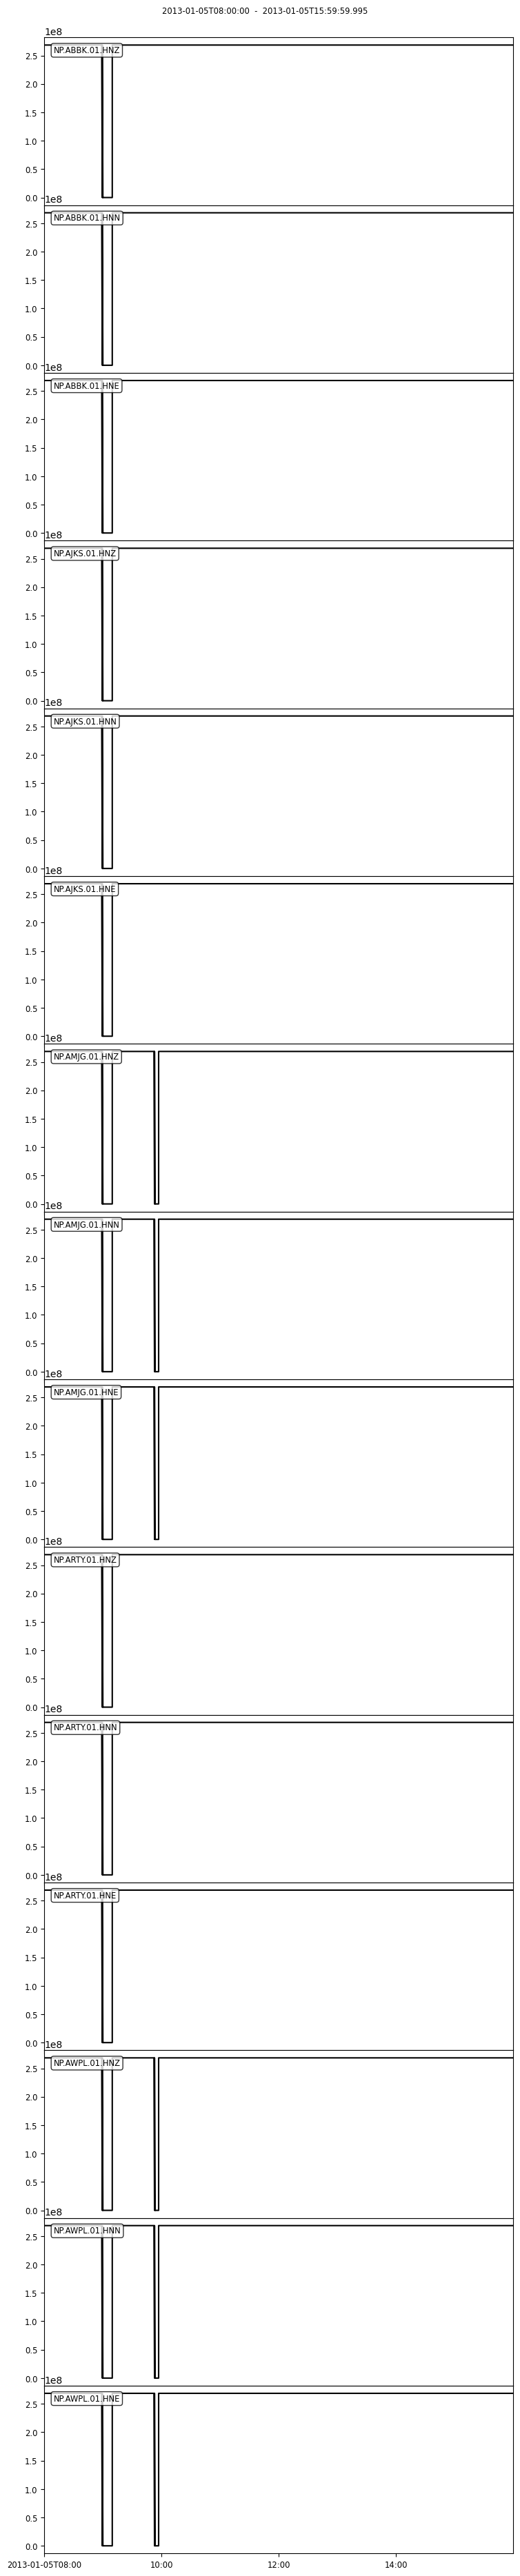

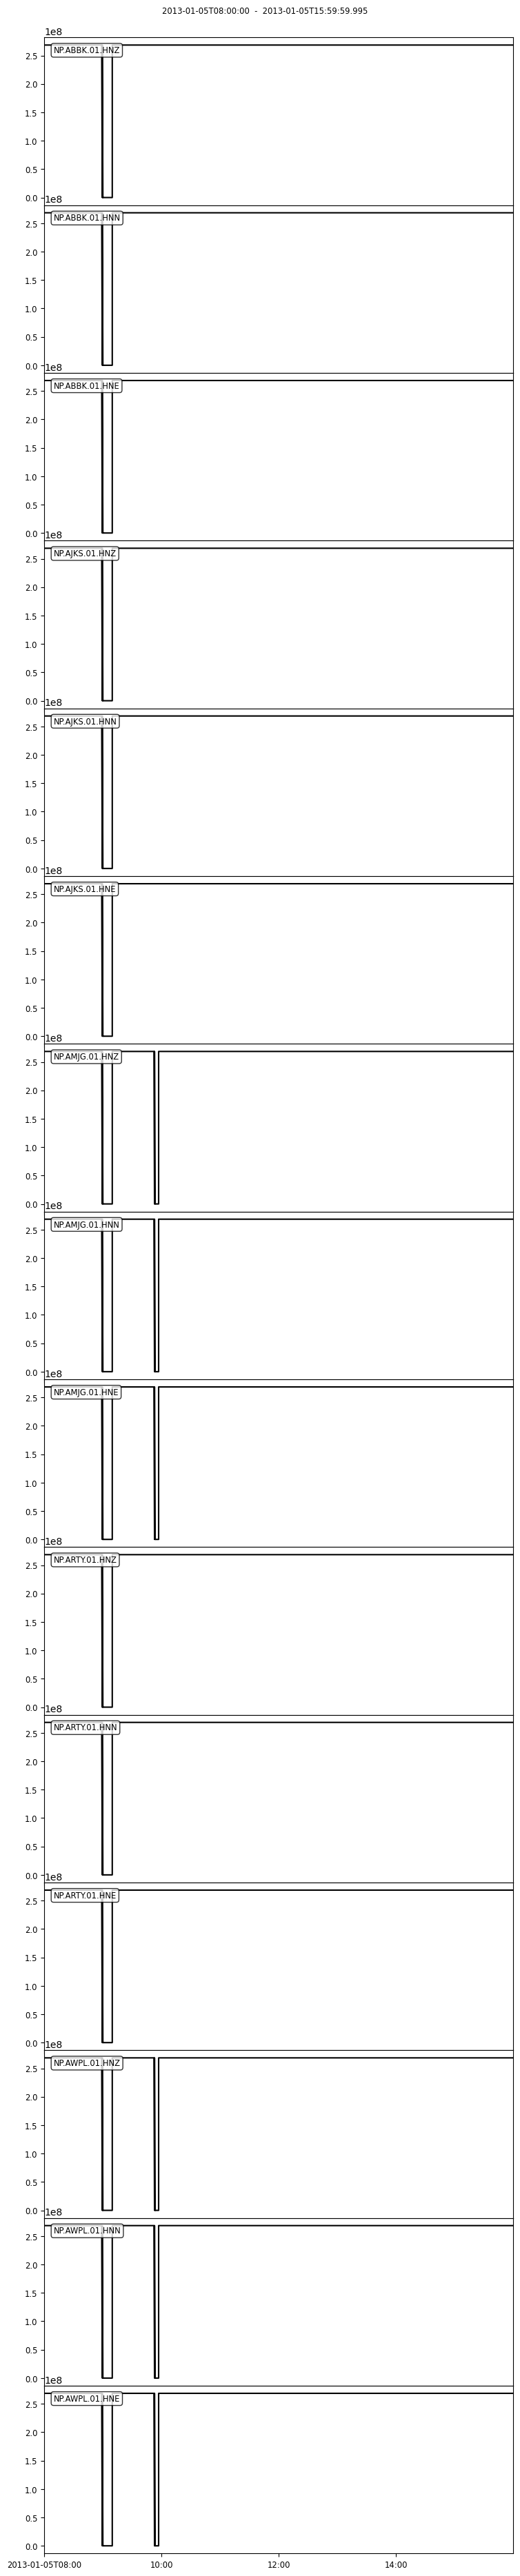

In [124]:
st.plot()